In [80]:
import util
import pandas as pd
import numpy as np
import twsq
from twsq.alpha import Alpha

In [81]:
layer1_coin_names = util.get_layer1_universe()


Fetched page 1 with 250 coins.
Fetched page 2 with 250 coins.
Fetched page 3 with 250 coins.


In [ ]:
class MRZSLong(Alpha):
    def filter_universe(self, universe, window_needed, freq='1h'):
        """
        Filter the provided universe to include only symbols for which data exists.

        Parameters:
        -----------
        universe : list
            List of asset symbols.
        window_needed : int
            Minimum number of bars required.
        freq : str, optional
            Frequency of the bars (default '1h').

        Returns:
        --------
        list
            Filtered list of symbols.
        """
        valid_symbols = []
        for symbol in universe:
            try:
                bars = self.get_lastn_bars(symbol + '/USD', n=window_needed, freq=freq)
                if not bars.empty :
                    valid_symbols.append(symbol)
            except Exception as e:
                continue
        return valid_symbols
    """
    Mean reversion breakout strategy for short positions.
    """

    def prepare(self, universe=None, enter_zscore = -3, exit_zscore = 1, enter_lookback=12, exit_lookback=15, dollar_exposure=100, freq = '1h'):
        """
        Initialize strategy parameters.
        Parameters:
        -----------
        universe : list
            List of asset symbols to consider (e.g. ['BTC/USD', 'ETH/USD']).
        enter_lookback : int, optional
            Lookback period for the entry threshold.
        exit_lookback : int, optional
            Lookback period for the exit threshold.
        dollar_exposure : float, optional
            Total dollar exposure.
        """
        if universe is None:
            universe = util.get_layer1_universe()
        universe = [str(symbol).upper() for symbol in universe]
        self.enter_lookback = enter_lookback
        self.exit_lookback = exit_lookback
        self.dollar_exposure = dollar_exposure
        self.enter_zscore = enter_zscore
        self.exit_zscore = exit_zscore
        window_needed = max(self.enter_lookback, self.exit_lookback)
        self.universe = self.filter_universe(universe, window_needed, freq=freq)
        self.current_signals = {symbol: 0 for symbol in universe}
    
    def rebalance(self):
        """
        Compute mr breakout signals and rebalance positions.
        Dollar exposure is total exposure across all short positions.
        """
        self.cancel_all_orders()
        signals = {}
        # Determine the number of bars needed from history.
        window_needed = max(self.enter_lookback, self.exit_lookback)
        
        # Compute signals for each asset.
        for symbol in self.universe:
            try:
                bars = self.get_lastn_bars(symbol + "/USD", n=window_needed, freq=self.freq)
                # Check if we have enough data.
                if bars.empty:
                    signal = 0
                else:
                    price_series = bars
                    ret = price_series['close'].pct_change()
                    current_ret = ret.iloc[-1]
                    current_price = price_series['close'].iloc[-1]
                    current_volume = price_series['volume'].iloc[-1]
                    daily_trading_volume = current_price * current_volume*24
                    if daily_trading_volume < self.dollar_exposure*100:
                        signal = 0
                        continue
                    enter_std = ret.iloc[-self.enter_lookback:].std()
                    exit_std = ret.iloc[-self.exit_lookback:].std()
                    if enter_std == 0 or exit_std == 0:
                        signal = 0
                        continue
                    enter_zscore = (current_ret - ret.iloc[-self.enter_lookback:].mean()) / ret.iloc[-self.enter_lookback:].std()
                    exit_zscore = (current_ret- ret.iloc[-self.exit_lookback:].mean()) / ret.iloc[-self.exit_lookback:].std()
                    # enter_max = price_series['close'].rolling(window=self.enter_lookback, min_periods = 1).max().iloc[-1]
                    # exit_min = price_series['close'].rolling(window=self.exit_lookback, min_periods = 1).min().iloc[-1]
                    
                    # Determine signal based on the most recent value.
                    if not price_series.empty:
                        if enter_zscore < self.enter_zscore:
                            signal = 1  # Enter short
                        elif exit_zscore > self.exit_zscore:
                            signal = 0   # Exit short
                        else:
                            signal = self.current_signals[symbol]
                    else:
                        signal = 0
            except Exception as e:
                print(f"Error processing {symbol}: {e}")
                signal = 0
            self.current_signals[symbol] = signal
            signals[symbol] = signal
        longs = [symbol for symbol, sig in signals.items() if sig == 1]
        nlong = len(longs)
        positions = self.get_pos()
        for symbol, signal in signals.items():
            try:
                price = self.get_current_price(symbol + '/USD')
                current_pos = positions.get(symbol, 0)
            except Exception as e:
                continue
            if signal == 1 and nlong > 0:
                trd = (self.dollar_exposure / nlong) / price - current_pos
                try:
                    if trd > 0:
                        self.create_order(
                            symbol+"/USD",
                            trd,
                            'buy',
                            price
                        )
                    elif trd == 0:
                        continue
                    else:
                        self.create_order(
                            symbol + "/USD",
                            abs(trd),
                            'sell',
                            price,
                        )
                except Exception as e:
                    print(f"Error creating order for {symbol}: {e}")
                    continue
            else:
                if current_pos > 0:
                    self.create_order(
                        symbol + "/USD",
                        current_pos,
                        'sell',
                        price,
                        route='True'
                    )
        self.route()
            

In [95]:
result = MRZSLong.run_backtest(start_ts='20231201', universe = layer1_coin_names, freq='1h', taker_fee = 0.004)

Running MRZSLong backtest: 100.00% done | Total PnL (USDT): 2,285 | Duration (s): 488  

In [ ]:
MRZSLong.run_live(freq='1h', universe = layer1_coin_names)

26-Feb-25 07:57:09: INFO: 🌱 Live trader initiated
26-Feb-25 07:57:11: INFO: Websocket connected
26-Feb-25 07:57:11: INFO: MRZSLong: Initial positions: None
26-Feb-25 07:57:12: INFO: Websocket connected


<Axes: xlabel='Date'>

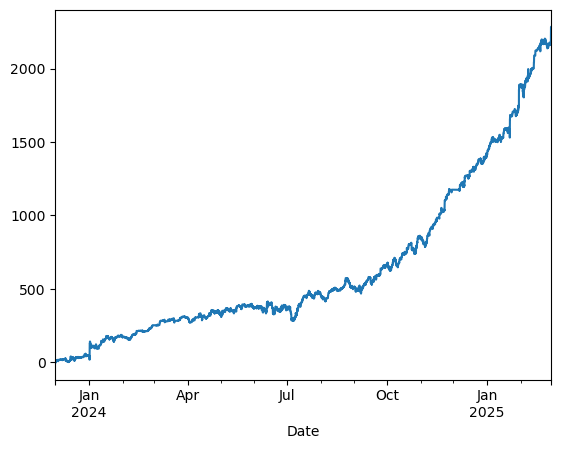

In [96]:
result.pos_pnl['port_val'].plot()

In [87]:
result.pos_pnl[result.pos_pnl['pnl'] < 0].sort_values(by='pnl', ascending=True)

,port_val,pnl,NEAR,USDT,BNB,RVN,FTM,ZIL,FLUX,ICP,...,DOGE,ADA,DOT,GALA,VET,IOTA,XLM,HBAR,SUI,ALGO
Date,,,,,,,,,,,,,,,,,,,,,
2025-02-03 02:00:00,51.676094,-1.624893e+01,1.892649,-48.323906,0.010579,0.000000,0.000000,0.0,16.111621,0.942534,...,0.0,8.987552,1.409284,0.0,187.515236,0.0,19.872814,0.0,2.10084,23.767083
2025-01-29 00:30:00,39.325870,-8.645196e+00,0.000000,-60.674130,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
2025-02-20 09:00:00,76.526085,-5.704333e+00,0.000000,-23.473915,0.000000,0.000000,0.000000,0.0,249.687890,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
2025-02-07 22:30:00,63.970108,-4.619706e+00,0.000000,-36.029892,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
2025-02-04 12:30:00,52.197597,-4.157534e+00,0.000000,-47.802403,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-21 22:30:00,75.192225,-1.027597e-02,0.000000,-24.807775,0.000000,7142.857143,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
2025-01-30 13:00:00,54.521894,-9.880102e-03,0.000000,-45.478106,0.000000,0.000000,98.328417,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000
2025-02-02 06:30:00,76.632907,-3.750831e-03,0.000000,76.632907,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000


In [88]:
ret = result.pos_pnl['pnl']/1000
ret.mean()/ret.std()*np.sqrt(365*24)

2.1104019218950767

<Axes: xlabel='Date'>

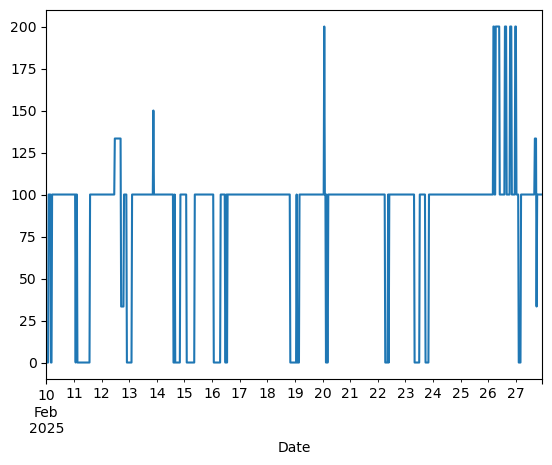

In [62]:
(result.pos_pnl['port_val']-result.pos_pnl['USDT']).plot()

In [ ]:
resul